# Bag of Words Models

<a href="https://colab.research.google.com/github/febse/ta2025/blob/main/02-01-BOW-Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In the introduction we have already seen a simple bag-of-words model for text classification using a decision tree classifier. Let's follow the same approach again, and we will apply it to a real dataset
of customer reviews. First, let's introduce the tools of trade for building bag-of-words models. At the heart of it, we count how many times we see one and the same word in a document. Consider the following toy corpus of four documents:


In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

corpus = [
    'the quick brown fox',
    'the fast brown dog',
    'the quick red fox',
    "the brown happy dog jumps over the lazy fox"

]

count_vectorizer = CountVectorizer()

term_matrix = count_vectorizer.fit_transform(corpus)
term_matrix_dense = term_matrix.toarray()

feature_names = count_vectorizer.get_feature_names_out()

pd.DataFrame(term_matrix_dense, columns=feature_names, index=[f'Doc {i+1}' for i in range(len(corpus))])

,brown,dog,fast,fox,happy,jumps,lazy,over,quick,red,the
Doc 1,1,0,0,1,0,0,0,0,1,0,1
Doc 2,1,1,1,0,0,0,0,0,0,0,1
Doc 3,0,0,0,1,0,0,0,0,1,1,1
Doc 4,1,1,0,1,1,1,1,1,0,0,2


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk

# Read in the data
df = pd.read_csv("https://github.com/febse/data/raw/refs/heads/main/ta/reviews.csv")
# Sample the data to speed up computation
# Comment out this line to match with lecture

df.head()


,Unnamed: 0,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0
1,34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0
2,248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0
3,167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0
4,73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0


In [10]:
# Remove missing values
df.dropna(inplace=True)

# Drop reviews with neutral ratings
df = df[df['Rating'] != 3]

df["positive"] = np.where(df['Rating'] > 3, 1, 0)
df.Reviews.head(10)

1     The phone needed a SIM card, would have been n...
2     I was 3 months away from my upgrade and my Str...
3                        an experience i want to forget
4           GREAT PHONE WORK ACCORDING MY EXPECTATIONS.
5     I fell in love with this phone because it did ...
6     I am pleased with this Blackberry phone! The p...
7     Great product, best value for money smartphone...
9             I've bought 3 no problems. Fast delivery.
10                         Great phone for the price...
11    My mom is not good with new technoloy but this...
Name: Reviews, dtype: object

In [13]:
# Most ratings are positive
(100 * df['positive'].value_counts(normalize=True)).round(2)

positive
1    74.75
0    25.25
Name: proportion, dtype: float64

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'],
                                                    df['positive'],
                                                    random_state=0)

In [16]:
print('X_train first entry:', X_train.iloc[0])
print('X_train shape: ', X_train.shape)

X_train first entry: Broke in like 20 mins
X_train shape:  (27662,)


## Logistic Regression Classifier

We'll use a bag-of-words representation with logistic regression to classify the sentiment of reviews.

In [17]:
# Create bag-of-words features using CountVectorizer
vectorizer = CountVectorizer(min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f'Number of features: {X_train_vec.shape[1]}')
print(f'Training set shape: {X_train_vec.shape}')
print(f'Test set shape: {X_test_vec.shape}')

Number of features: 6020
Training set shape: (27662, 6020)
Test set shape: (9221, 6020)


In [18]:
# Train logistic regression classifier
logreg = LogisticRegression(max_iter=1000, random_state=0)
logreg.fit(X_train_vec, y_train)

# Make predictions
y_pred = logreg.predict(X_test_vec)
y_pred_proba = logreg.predict_proba(X_test_vec)[:, 1]

# Calculate accuracy and AUC
accuracy = logreg.score(X_test_vec, y_test)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'AUC Score: {auc_score:.4f}')

Accuracy: 0.9281
AUC Score: 0.9620


### Confusion Matrix

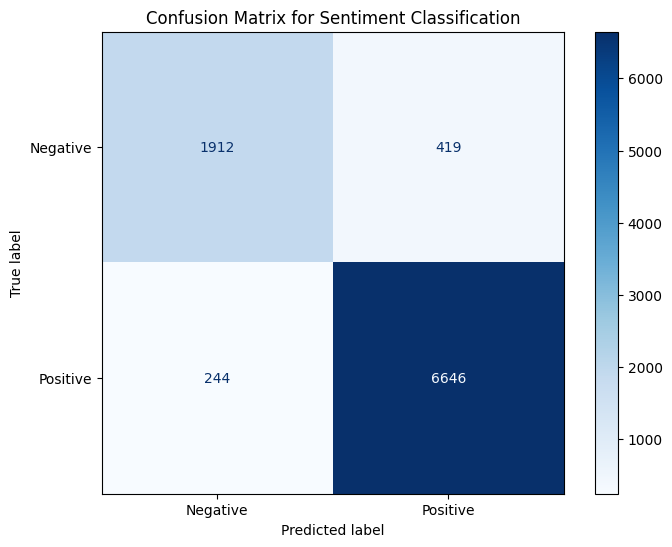


Confusion Matrix:
True Negatives: 1912
False Positives: 419
False Negatives: 244
True Positives: 6646


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Sentiment Classification')
plt.show()

print(f'\nConfusion Matrix:')
print(f'True Negatives: {cm[0,0]}')
print(f'False Positives: {cm[0,1]}')
print(f'False Negatives: {cm[1,0]}')
print(f'True Positives: {cm[1,1]}')

### ROC Curve

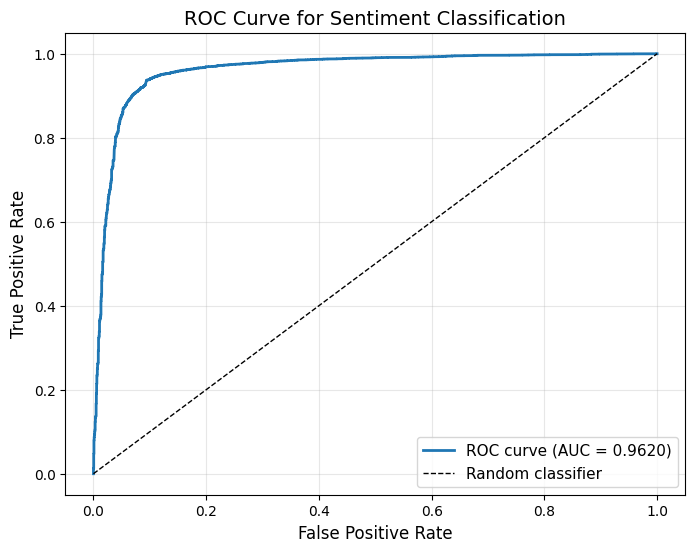

In [20]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Sentiment Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.show()

### Most Important Features

The logistic regression coefficients tell us which words are most associated with positive and negative sentiment.

In [21]:
# Get feature names and coefficients
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = logreg.coef_[0]

# Create a dataframe with features and their coefficients
feature_coef = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False)

# Top 20 features associated with positive sentiment
print("Top 20 features most associated with POSITIVE sentiment:")
print(feature_coef.head(20).to_string(index=False))

print("\n" + "="*60 + "\n")

# Top 20 features associated with negative sentiment
print("Top 20 features most associated with NEGATIVE sentiment:")
print(feature_coef.tail(20).to_string(index=False))

Top 20 features most associated with POSITIVE sentiment:
   feature  coefficient
 excelente     3.613686
  excelent     3.557023
 excellent     3.456950
      love     3.083990
 perfectly     3.028927
   perfect     2.919632
     loves     2.892174
   exactly     2.825756
   amazing     2.810084
 wonderful     2.693352
     great     2.677249
   awesome     2.631543
      best     2.595770
      wise     1.954008
complaints     1.866984
     bueno     1.850863
  exelente     1.838626
 fantastic     1.838323
    launch     1.752442
      good     1.749161


Top 20 features most associated with NEGATIVE sentiment:
     feature  coefficient
        nope    -1.894788
unresponsive    -1.905985
      unable    -1.930117
     damaged    -1.945905
   difficult    -1.956329
disappointed    -1.998594
     blocked    -2.045444
     freezes    -2.065218
       doesn    -2.104301
    horrible    -2.200190
     garbage    -2.305670
        slow    -2.337399
      broken    -2.380157
        poor    

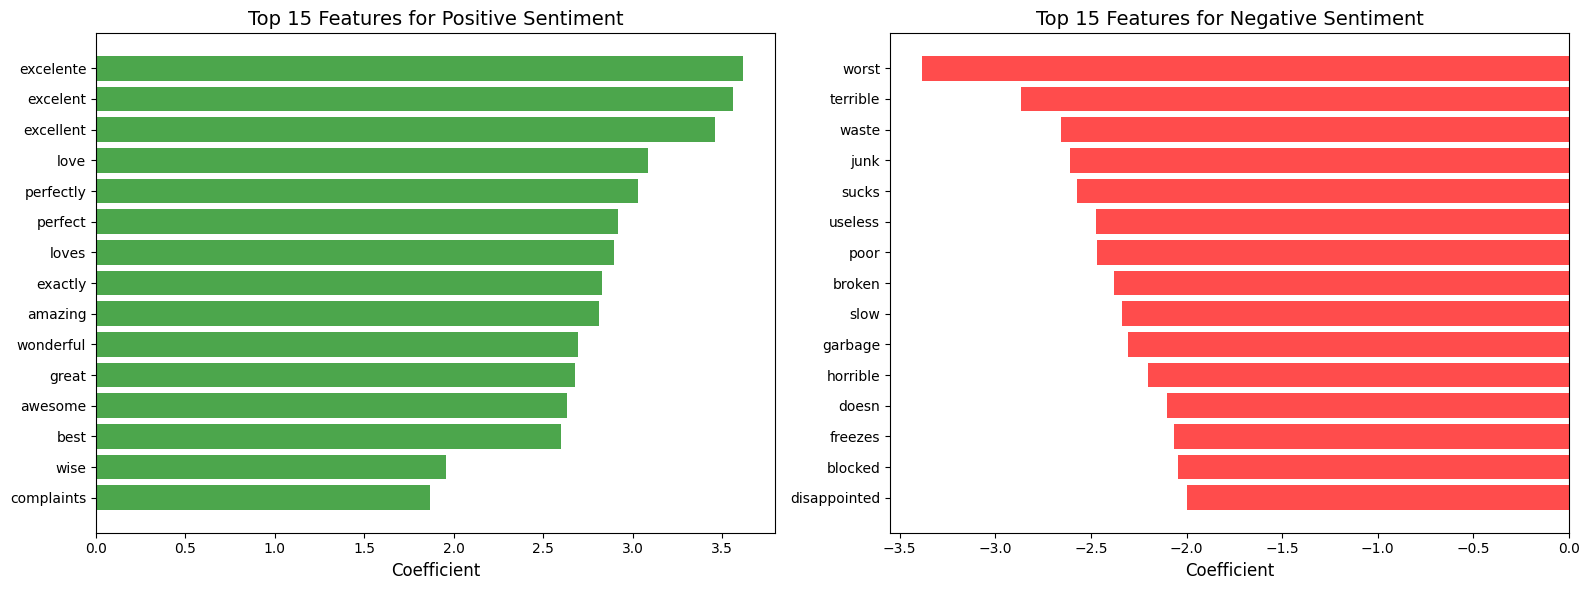

In [ ]:
# Visualize top features for each class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top positive features
top_positive = feature_coef.head(15)

ax1.barh(range(len(top_positive)), top_positive['coefficient'], color='green', alpha=0.7)
ax1.set_yticks(range(len(top_positive)))
ax1.set_yticklabels(top_positive['feature'])
ax1.set_xlabel('Coefficient', fontsize=12)
ax1.set_title('Top 15 Features for Positive Sentiment', fontsize=14)
ax1.invert_yaxis()

# Top negative features
top_negative = feature_coef.tail(15).sort_values('coefficient', ascending=True)

ax2.barh(range(len(top_negative)), top_negative['coefficient'], color='red', alpha=0.7)
ax2.set_yticks(range(len(top_negative)))
ax2.set_yticklabels(top_negative['feature'])
ax2.set_xlabel('Coefficient', fontsize=12)
ax2.set_title('Top 15 Features for Negative Sentiment', fontsize=14)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [28]:
# Print a sample of feature names

print("Sample feature names from the CountVectorizer:")
print(feature_names[:20])  # Print first 20 feature names as a sample

Sample feature names from the CountVectorizer:
['00' '000' '01' '02' '09' '10' '100' '1000' '102' '1020' '1080' '1080p'
 '109' '10gb' '10th' '11' '110' '110v' '115' '119']


In [29]:
# Print a sample of the longest feature names

longest_features = sorted(feature_names, key=len, reverse=True)[:20]
print("\nSample of the longest feature names:")
for feature in longest_features:
    print(feature)


Sample of the longest feature names:
characteristics
congratulations
functionalities
interchangeable
internationally
recommendations
responsabilidad
straightforward
synchronization
troubleshooting
unintentionally
communications
disappointment
funcionamiento
indestructible
intermittently
malfunctioning
recommendation
remanufactured
representative


In [30]:
# A sample of the shortest feature names

shortest_features = sorted(feature_names, key=len)[:20]
print("\nSample of the shortest feature names:")
for feature in shortest_features:
    print(feature)


Sample of the shortest feature names:
00
01
02
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
